# Fuel Prices Analysis (United Kingdom Data)

## Research Goals

- Identify how fuel prices fluctuate over time and determine key patterns.
- Analyze the impact of external factors such as supply chain disruptions, oil prices, VAT, inflation, and geopolitical events on fuel prices.
- Compare fuel price trends across different time periods to understand long-term changes.
- Use machine learning models to predict future fuel price movements based on historical data.
- Store and process data efficiently using **AWS S3** and **Snowflake**, ensuring scalability and reliability.
- Present findings through interactive **Power BI** dashboards and **Plotly Dash** visualizations for clear and actionable insights.
- Implement a **deployment mode** for predictive models, allowing real-time or batch forecasting of fuel prices.

## Step 3: Oil.ipynb Objectives

### Objectives:
- Collect real-time and historical **Brent Crude** oil price data from various sources.
- Process and clean the collected data to ensure consistency and accuracy.
- Compute and analyze **monthly average Brent Crude oil prices**.
- Perform **Exploratory Data Analysis (EDA)** to identify trends, seasonality, and anomalies.

### 3.1 Import Libraries

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from bs4 import BeautifulSoup
import requests

---

### 3.2 Upload Data from URL
We will retrieve historical **Brent Crude oil price data** from the **U.S. Energy Information Administration (EIA)**.  
The dataset can be accessed at the following URL:  
[EIA Brent Crude Oil Prices (Monthly)](https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RBRTE&f=M)


In [116]:
# URL of the page with Brent Crude oil prices
url = "https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RBRTE&f=M"

In [117]:
# Send request to get the page content
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all tables on the page
    tables = soup.find_all("table")

    # Find the table with oil price data
    for table in tables:
        rows = table.find_all("tr")
        first_row = rows[0].find_all("th")
        headers = [th.text.strip() for th in first_row]

        if "Year" in headers:
            # Extract data from the table
            data = []
            for row in rows[1:]:  # Skip header row
                cols = row.find_all("td")
                cols = [col.text.strip() for col in cols]
                if cols and cols[0].isdigit():  # Ensure it's a valid year row
                    year = cols[0]
                    for month_idx, price in enumerate(cols[1:], start=1):  # Iterate over months
                        if price:  # Ignore empty cells
                            year_month = f"{year}-{month_idx:02d}"  # Convert to YYYY-MM format
                            data.append([year_month, float(price)])

            # Convert to DataFrame
            df = pd.DataFrame(data, columns=["Year-Month", "Price"])
            print(df.head())  # Display first rows
else:
    print("Failed to retrieve the webpage")

  Year-Month  Price
0    1987-05  18.58
1    1987-06  18.86
2    1987-07  19.86
3    1987-08  18.98
4    1987-09  18.31
  Year-Month  Price
0    1987-05  18.58
1    1987-06  18.86
2    1987-07  19.86
3    1987-08  18.98
4    1987-09  18.31
  Year-Month  Price
0    1987-05  18.58
1    1987-06  18.86
2    1987-07  19.86
3    1987-08  18.98
4    1987-09  18.31


In [118]:
df.head()

,Year-Month,Price
0,1987-05,18.58
1,1987-06,18.86
2,1987-07,19.86
3,1987-08,18.98
4,1987-09,18.31


In [119]:
df.tail()

,Year-Month,Price
448,2024-09,74.02
449,2024-10,75.63
450,2024-11,74.35
451,2024-12,73.86
452,2025-01,79.27


In [120]:
# Save cleaned data
df.to_csv("oil_prices.csv", index=False)

---

### 3.3 Data Preparation

In [121]:
# Load the dataset
df = pd.read_csv("C:/Users/Zana/Desktop/fuel-analytics/14.Oil/oil_prices.csv")

In [122]:
df.head()

,Year-Month,Price
0,1987-05,18.58
1,1987-06,18.86
2,1987-07,19.86
3,1987-08,18.98
4,1987-09,18.31


In [123]:
# Convert "Year-Month" to datetime format for easy filtering
df["Year-Month"] = pd.to_datetime(df["Year-Month"])

# Filter the DataFrame to keep only rows within the range and reset index
df = df[(df["Year-Month"] >= "2019-01-01") & (df["Year-Month"] <= "2024-12-01")].reset_index(drop=True)

# Save the cleaned data
df.to_csv("filtered_oil_prices.csv", index=False)

In [124]:
df.head()

,Year-Month,Price
0,2019-01-01,59.41
1,2019-02-01,63.96
2,2019-03-01,66.14
3,2019-04-01,71.23
4,2019-05-01,71.32


Convert price per barrel to price per liter
We need the price per liter because fuel is sold to consumers in liters, not barrels.
This conversion allows us to analyze and predict fuel costs in a format relevant to end-users,
Making it more applicable for real-world forecasting and economic analysis.

In [125]:
# Convert price per barrel to price per liter
df["Price_per_Liter"] = df_filtered["Price"] / 159

In [126]:
df.head()

,Year-Month,Price,Price_per_Liter
0,2019-01-01,59.41,0.116855
1,2019-02-01,63.96,0.118616
2,2019-03-01,66.14,0.124906
3,2019-04-01,71.23,0.119371
4,2019-05-01,71.32,0.115157


In [127]:
df.drop(columns=["Price"])

,Year-Month,Price_per_Liter
0,2019-01-01,0.116855
1,2019-02-01,0.118616
2,2019-03-01,0.124906
3,2019-04-01,0.119371
4,2019-05-01,0.115157
...,...,...
67,2024-08-01,0.114088
68,2024-09-01,0.109371
69,2024-10-01,0.116164
70,2024-11-01,0.118176


---

### 3.4 Data Quality Checks
Tasks:

- Check for missing values
- Check for duplicates
- Check for zero values (to detect potential data issues)

In [128]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()

# Check for zero values in price columns
zero_values = (df == 0).sum()

# Display results
print("Missing Values:\n", missing_values)
print("\nDuplicate Rows:", duplicate_rows)
print("\nZero Values:\n", zero_values)

Missing Values:
 Year-Month         0
Price              0
Price_per_Liter    0
dtype: int64

Duplicate Rows: 0

Zero Values:
 Year-Month         0
Price              0
Price_per_Liter    0
dtype: int64


---

### 3.5 Data Summary and Statistics

In [129]:
df.dtypes

Year-Month         datetime64[ns]
Price                     float64
Price_per_Liter           float64
dtype: object

In [130]:
df.head()

,Year-Month,Price,Price_per_Liter
0,2019-01-01,59.41,0.116855
1,2019-02-01,63.96,0.118616
2,2019-03-01,66.14,0.124906
3,2019-04-01,71.23,0.119371
4,2019-05-01,71.32,0.115157


In [131]:
df.drop(columns=["Price"], inplace=True)

In [132]:
df.head()

,Year-Month,Price_per_Liter
0,2019-01-01,0.116855
1,2019-02-01,0.118616
2,2019-03-01,0.124906
3,2019-04-01,0.119371
4,2019-05-01,0.115157


In [133]:
# Save cleaned data
df.to_csv("oil_prices.csv", index=False)

In [134]:
df.dtypes

Year-Month         datetime64[ns]
Price_per_Liter           float64
dtype: object

In [135]:
df.describe()

,Year-Month,Price_per_Liter
count,72,72.000000
mean,2021-12-15 22:40:00,0.120179
min,2019-01-01 00:00:00,0.078050
25%,2020-06-23 12:00:00,0.107799
50%,2021-12-16 12:00:00,0.117296
75%,2023-06-08 12:00:00,0.124638
max,2024-12-01 00:00:00,0.226541
std,NaN,0.026225


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year-Month       72 non-null     datetime64[ns]
 1   Price_per_Liter  72 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 KB


---

### 3.6 Brent Crud Price Trends Over Time
Task: Plot a line chart to visualize how petrol and diesel prices changed over time.

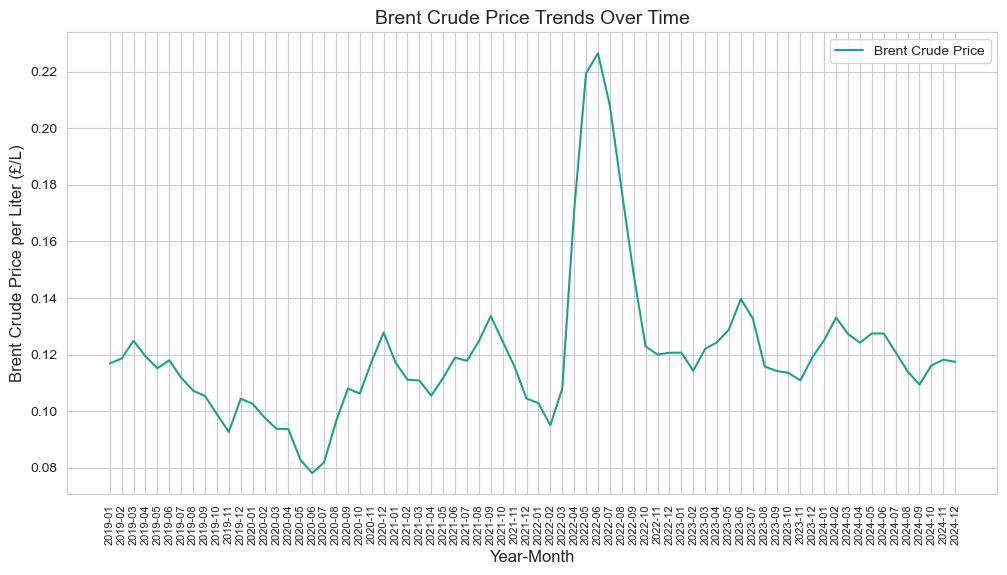

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 6))

# Line plot of Oil Price per Liter over time with Viridis colormap
sns.lineplot(x=df["Year-Month"].dt.strftime("%Y-%m"), y=df["Price_per_Liter"], data=df, color=sns.color_palette("viridis")[3], label="Brent Crude Price")

# Formatting
plt.xticks(rotation=90, fontsize=8)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Brent Crude Price per Liter (£/L)", fontsize=12)
plt.title("Brent Crude Price Trends Over Time", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

## Findings from the Brent Crude Price Trend Analysis

## General Trend:
- The price of Brent Crude per liter fluctuates over time, with noticeable peaks and troughs.
- There was a significant price spike around 2022, likely due to geopolitical events or supply chain disruptions.
- Prices dropped sharply in 2020, potentially due to the COVID-19 pandemic reducing global oil demand.

## Volatility:
- The data shows high volatility, indicating external market forces significantly impact crude oil prices.
- There are multiple mini-peaks and drops, showing frequent market adjustments.

## Seasonality:
- A pattern of repeating price movements suggests possible seasonal effects, which we will confirm using Seasonality & Trend Decomposition.

## Next Steps:
- **Boxplot Analysis** – Identify outliers, median, and price distribution.

---

### 3.7 Boxplot for Brent Crude Price Distribution

In [140]:
df.head()

,Year-Month,Price_per_Liter
0,2019-01-01,0.116855
1,2019-02-01,0.118616
2,2019-03-01,0.124906
3,2019-04-01,0.119371
4,2019-05-01,0.115157


<module 'matplotlib.pyplot' from 'C:\\Users\\Zana\\miniconda3\\envs\\pymc_env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

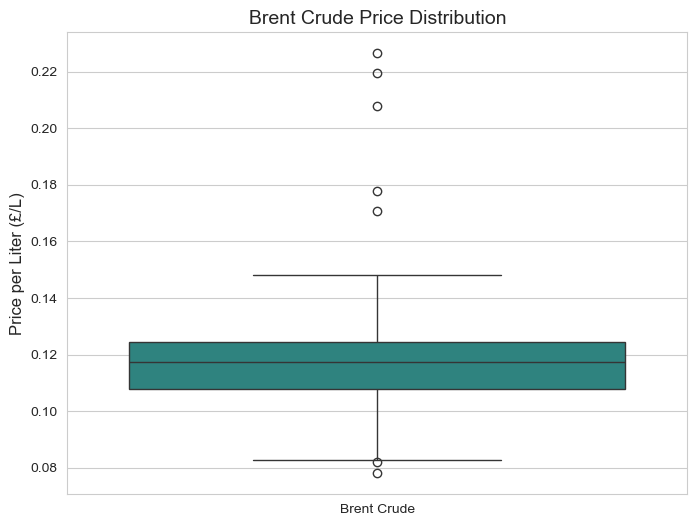

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")

# Create a dummy categorical column for hue
df["Category"] = "Brent Crude"

# Create boxplot with correct hue assignment (Seaborn v0.14+ fix)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["Category"], y=df["Price_per_Liter"], hue=df["Category"], palette="viridis", legend=False)

# Formatting
plt.xlabel("")
plt.ylabel("Price per Liter (£/L)", fontsize=12)
plt.title("Brent Crude Price Distribution", fontsize=14)
plt


---

## Findings from the Boxplot Analysis

## Price Distribution
- The median Brent Crude price per liter is around £0.12.  
- Most prices fall within the interquartile range (IQR) between £0.11 and £0.13.  

## Outliers
- Several high outliers are observed above £0.16, with a few extreme values exceeding £0.22.  
- A few low outliers below £0.09 suggest occasional price drops.  

## Volatility & Stability
- The whiskers show moderate variation, indicating some fluctuations in price.  
- The spread suggests occasional price instability, possibly due to external market factors.

---

# **Completed Work: Fuel Prices Analysis (United Kingdom Data)**

## **1. Data Collection & Processing**
- Retrieved historical Brent Crude oil price data from the U.S. Energy Information Administration (EIA).
- Used web scraping (BeautifulSoup) to extract monthly Brent Crude prices from 1987 to 2025.
- Converted price per barrel to price per liter for relevance to consumer fuel costs.
- Filtered dataset to focus on the period from **2019 to 2024**.
- Cleaned data by handling missing values, duplicates, and ensuring consistency.

## **2. Data Storage & Transformation**
- Saved processed data in CSV format.
- Formatted "Year-Month" column to **datetime** for better filtering and trend analysis.
- Conducted data quality checks:
  - **No missing values**
  - **No duplicate entries**
  - **No zero values detected**

## **3. Exploratory Data Analysis (EDA)**
- **Trend Analysis:** 
  - Created a line chart to visualize Brent Crude price changes over time.
  - Identified major fluctuations, including **2022 price spikes** and **2020 drops**.
  - Observed seasonal price patterns.

- **Boxplot Analysis:**
  - **Price Distribution:** Median Brent Crude price per liter is **£0.12**.
  - **Interquartile Range (IQR):** Prices mostly fall between **£0.11 and £0.13**.
  - **Outliers:** 
    - High outliers above **£0.16**, with extreme values exceeding **£0.22**.
    - Low outliers below **£0.09**, indicating occasional price drops.
  - **Volatility:** Moderate variation suggests external factors influence prices.

## **4. Data Visualization**
- Created **time-series line plot** for Brent Crude price trends.
- Generated **boxplot** to highlight price distribution and outliers.
- Applied formatting for readability, including **rotated x-axis labels**, **grid lines**, and **legend styling**.
